# Introduction to Bayesian DL

이 세션에서는 배경별 베이지안 딥러닝에 설명된 대로 기본적인 베이지안 딥러닝 모델을 이해하고 구현하는 것을 목표로 한다.
![](https://github.com/charlesollion/dlexperiments/raw/master/6-Bayesian-DL/BDLworkflow.png)

**What this is about:**

- Pytorch로 학습하기
- 기본 BBB 빌딩 블록 이해


## Why BayesByBackprop

우리의 목표는 파이토치 같은 기존 프레임워크를 사용하고 신경망을 훈련하는 표준 방식을 고수한다.:

- Stochastic Gradient Descent(SGD) 또는 변형된 방식을 사용한다.
- 그런 다음 임의의 mini-batch(데이터가 클 수 있음)로 학습한다.
- 그라디언트를 직접 계산하지 않고 자동 차별화를 활용하고 싶다.
- 병렬 컴퓨팅의 이점을 활용하고 싶습니다.

## Installation

In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

## The dataset

'Wine Qiuality'을 사용합니다. 4,898개의 예가 포함된 레드 와인 하위 집합을 사용합니다. 이 데이터 집합에는 와인의 11가지 물리화학적 특징이 수치로 표시되어 있으며, 0에서 10 사이의 점수인 와인 품질을 예측하는 것이 과제이다.

전문가들은 정수로 점수를 주었지만, 단순하고 신뢰 구간을 쉽게 해석하기 위해 먼저 0에서 10 사이의 연속 값으로 간주하고 이를 회귀 작업으로 처리할 것입니다. 데이터를 보다 연속적으로 만들기 위해 y에 작은 관측 노이즈를 추가한다.

In [3]:
# load data
df = pd.read_csv('../dataset/wine_quality.csv')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,rate
0,7.6,0.32,0.34,18.35,0.054,44.0,197.0,1.00080,3.22,0.55,9.0,5.0
1,6.3,0.27,0.49,1.20,0.063,35.0,92.0,0.99110,3.38,0.42,12.2,6.0
2,5.3,0.43,0.11,1.10,0.029,6.0,51.0,0.99076,3.51,0.48,11.2,4.0
3,6.6,0.41,0.27,10.70,0.110,20.0,103.0,0.99672,3.08,0.41,9.0,6.0
4,5.9,0.34,0.30,3.80,0.035,57.0,135.0,0.99016,3.09,0.34,12.0,6.0


In [4]:
df.shape

(4898, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  rate                  4898 non-null   float64
dtypes: float64(12)
memory usage: 459.3 KB


In [8]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,rate
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


## Feature Engineering

In [10]:
X = df.drop('rate', axis=1)
y = df['rate']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.15, 
    random_state=42
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4163, 11), (735, 11), (4163,), (735,))

In [12]:
# add a bit of noise to y_train
y_train = y_train + np.random.normal(0,0.2, size=y_train.shape)

In [13]:
# mean = 0 ; standard deviation = 1.0
scaler = preprocessing.StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
# transform to torch tensor
tensor_X_train = torch.from_numpy(X_train).float().to(device) 
tensor_y_train = torch.from_numpy(y_train.values).float().to(device) 
tensor_X_test = torch.from_numpy(X_test).float().to(device) 
tensor_y_test = torch.from_numpy(y_test.values).float().to(device) 

In [15]:
batch_size = 256

In [16]:
# build dataset and dataloader torch objects
dataset_train = TensorDataset(
    tensor_X_train, tensor_y_train
)
dataset_test = TensorDataset(
    tensor_X_test, tensor_y_test
)
dataloader_train = DataLoader(
    dataset_train, 
    batch_size=batch_size, 
    shuffle=True
)
dataloader_test = DataLoader(
    dataset_test, 
    batch_size=batch_size
)

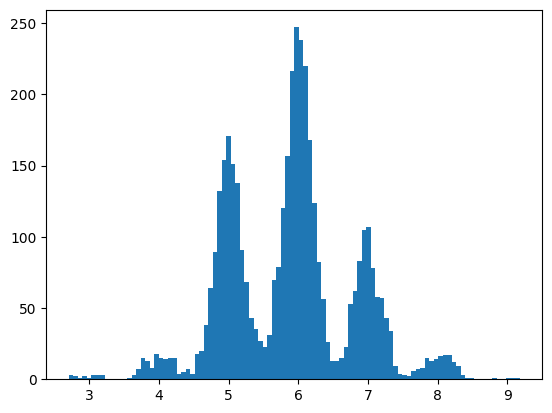

In [17]:
import matplotlib.pyplot as plt
plt.hist(y_train, bins=100);

## Baseline: Vanila Neural Network

We create a standard deterministic neural network model as a baseline.

<img src="https://raw.githubusercontent.com/charlesollion/dlexperiments/master/6-Bayesian-DL/stochasticNN.png" width="400" height="200">

In [18]:
import torch.nn as nn

class BaselineModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(BaselineModel, self).__init__()
        self.hidden_layer = nn.Linear(input_dim, hidden_dim)
        self.out_layer = nn.Linear(hidden_dim, 1)
        self.act = torch.relu
        
    def forward(self, inputs):
        h = self.hidden_layer(inputs)
        h = self.act(h)
        output = self.out_layer(h)
        
        # return에 실험을 위한 자리 표시자인 더미 출력을 추가
        return output, None

In [19]:
import torch.optim as optim
from tqdm import tqdm

def train_model(model, loss, num_epochs):
    optimizer = optim.RMSprop(model.parameters(), lr=0.003)
    losses = []
    model.train()
    for e in tqdm(range(num_epochs)):
        for x, y in dataloader_train:
            optimizer.zero_grad()
            loss_value = loss(model(x), y)
            loss_value.backward()
            losses.append(loss_value.detach().cpu().item())
            optimizer.step()
    return losses


def eval_model(model):
    model.eval()
    errors = []
    for x,y in dataloader_test:
        y_hat, _ = model(x)
        errors.append(((torch.squeeze(y_hat) - torch.squeeze(y))**2).detach().cpu().numpy())
  
    rmse = np.sqrt(np.mean(np.concatenate(errors, axis=None)))
    return round(rmse, 3)

In [20]:
baseline_model = BaselineModel(11, 32).to(device)
baseline_model

BaselineModel(
  (hidden_layer): Linear(in_features=11, out_features=32, bias=True)
  (out_layer): Linear(in_features=32, out_features=1, bias=True)
)

In [21]:
[p.numel() for p in baseline_model.parameters()]
# hidden layer W, hidden layer b, output layer W, output layer b

[352, 32, 32, 1]

### Baseline evaluations

In [22]:
rmse = eval_model(baseline_model)
print(f"untrained RMSE: {rmse:.3f}")

untrained RMSE: 5.980


In [23]:
class Constant():
    def eval(self):
        pass
    
    def __call__(self, x):
        # Always return 5.81...
        return torch.ones((x.shape[0], 1)).to(device) * np.mean(y_train), None

rmse = eval_model(Constant())
print(f"constant model RMSE: {round(rmse, 3):.3f}")

constant model RMSE: 0.916


### Training model

100%|██████████| 50/50 [00:03<00:00, 15.76it/s]


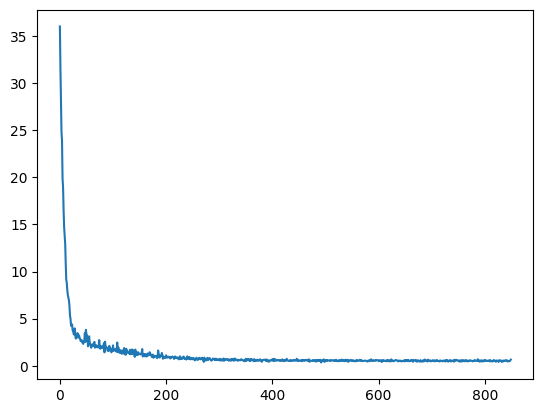

In [24]:
def simple_mse_loss(model_outputs, y_true):
    y_hat, _ = model_outputs
    y_hat = torch.squeeze(y_hat)
    y_true = torch.squeeze(y_true)
    return torch.nn.MSELoss()(y_hat, y_true) 

losses = train_model(
    baseline_model, 
    simple_mse_loss, 
    50
)

plt.plot(losses);

In [25]:
rmse = eval_model(baseline_model)
print(f"untrained RMSE: {rmse:.3f}")

untrained RMSE: 0.790


In [26]:
samples = 10

# first ten examples
examples_torch, y_test = next(iter(dataloader_test))  # 라벨 포함 데이터 가져오기
predicted, _ = baseline_model(examples_torch[:samples])  # 모델 예측
predicted = predicted.detach().cpu().numpy()  # NumPy로 변환

for idx in range(samples):
    # 실제값과 예측값 출력
    print(f"Predicted: {round(float(predicted[idx][0]), 1)} - Actual: {y_test[idx].item()}")

Predicted: 5.8 - Actual: 6.0
Predicted: 5.3 - Actual: 6.0
Predicted: 5.1 - Actual: 4.0
Predicted: 5.4 - Actual: 5.0
Predicted: 6.8 - Actual: 7.0
Predicted: 5.9 - Actual: 6.0
Predicted: 5.6 - Actual: 7.0
Predicted: 5.5 - Actual: 5.0
Predicted: 6.0 - Actual: 7.0
Predicted: 5.6 - Actual: 6.0


## Simple Bayesian Neural Network

우리의 목표는 Pytorch를 사용하여 단일 계층 베이지안 신경망을 구축하는 것이다.

<img src="https://raw.githubusercontent.com/charlesollion/dlexperiments/master/6-Bayesian-DL/stochasticNN.png" width="400" height="200">

단위 가우스 선행과 대각선 공분산 다변량 가우스 사후확률을 정의한다.

다음과 같은 알고리즘이 있다면:

1. Sample $\epsilon ∼ N(0, I)$.
2. Let $w = µ + log(1 + exp(ρ)) ◦ \epsilon$.
3. Let $θ = (µ, ρ)$.
4. Let $f(w, θ) = log q(w|θ) − log P(w)P(D|w)$.
5. Compute gradients with respect to everything


기울기의 ∂𝑓(𝑤,θ)∂𝑤 항은 신경망에서 일반적인 역전파 알고리즘으로 구한 기울기와 정확히 일치합니다. 따라서 놀랍게도 평균과 표준 편차를 모두 학습하려면 역전파를 통해 찾은 일반적인 기울기를 간단히 계산한다.

𝑀 미니 배치 𝐷𝑖의 데이터로 작업할 때 저자는 다음과 같은 (동등한) 비용 함수를 제안하여 차별화할 수 있다.

$$f(w, θ, D_i) = − log P(D_i|w) + \frac{1}{M} KL[q(w|θ) || P(w)] $$


이는 비용 함수가 이전과 같이 표준 mse 손실에 해당하는 두 개의 항과 정규화 항, 즉 후방 q와 이전 사이의 KL divergence로 분리되어 있으므로 편리합니다. 다른 방식으로 선택할 수 있는 가중치( 1𝑀 )가 있다는 점에 유의.

### Simple Bayesian By Backprop Layer

다음에서는 확률적 가중치로 구성된 선형 레이어를 구현하는 것으로 시작합니다. 출력 레이어는 이전과 동일하게 유지된다.

In [27]:
class BnnTorch(nn.Module):
    def __init__(self, input_dim, hidden_dim, activation=None):
        super(BnnTorch, self).__init__()
        n = input_dim * hidden_dim
        self.mu = nn.Parameter(torch.zeros((n), dtype=torch.float32))
        self.rho  = nn.Parameter(torch.log(torch.expm1(torch.ones((n), dtype=torch.float32))))
        self.out_layer = nn.Linear(hidden_dim, 1)
        self.act = activation
        self.hidden_dim = hidden_dim
        self.prior = torch.distributions.Normal(loc=torch.zeros((n), device=device, dtype=torch.float32),
                                                scale=torch.ones((n), device=device, dtype=torch.float32))
        self.posterior = torch.distributions.Normal(loc=self.mu, 
                                                    scale=torch.log(1.+torch.exp(self.rho)))
        self.kl_func = torch.distributions.kl.kl_divergence
        self.batch_norm = torch.nn.BatchNorm1d(input_dim)

        
    def forward(self, inputs):
        inputs = self.batch_norm(inputs)
        q = torch.distributions.Normal(loc=self.mu, 
                                       scale=torch.log(1.+torch.exp(self.rho)))
        
        kl = torch.sum(self.kl_func(q, self.prior))
        # we use q.rsample() which uses the reparametrization trick instead of 
        # q.sample() which breaks the auto-differentation path
        w = q.rsample() 
        w = w.reshape((-1, self.hidden_dim))
        h = inputs @ w
        if self.act is not None:
            h = self.act(h)
        output = self.out_layer(h)
        return output, kl

In [28]:
bnn_torch = BnnTorch(11, 32, torch.nn.functional.relu).to(device)
[p.numel() for p in bnn_torch.parameters()]
#mu, rho, W_output, b_output, batch_norm mu, batch_norm sigma

[352, 352, 32, 1, 11, 11]

100%|██████████| 200/200 [00:16<00:00, 12.01it/s]


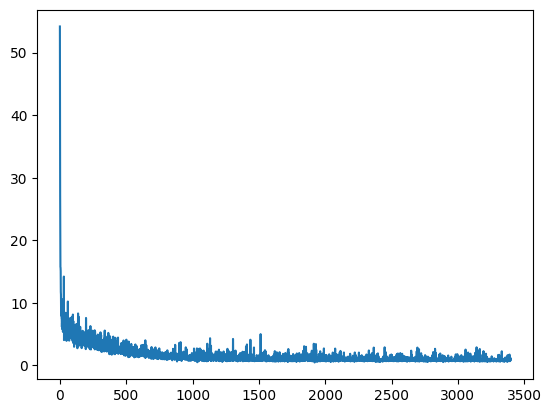

In [29]:
kl_weight = 1. / batch_size

def mse_kl_loss(model_outputs, y_true):
    y_hat, kl = model_outputs
    y_hat = torch.squeeze(y_hat)
    y_true = torch.squeeze(y_true)
    mse = torch.nn.MSELoss()(y_hat, y_true)
    return mse + kl * kl_weight

losses = train_model(bnn_torch, mse_kl_loss, 200)
plt.plot(losses);

In [31]:
def compute_predictions(model, dataset, iterations=20):
    model.eval()
    single_item_dataloader_test = DataLoader(dataset, batch_size=1)
    
    # Extract target labels from dataset and ensure they are on CPU
    y_test = np.array([label.cpu().item() for _, label in dataset])  # Ensure labels are on CPU
    predicted = np.zeros((len(y_test), iterations))  # Initialize predictions array

    for j, (x, y) in tqdm(enumerate(single_item_dataloader_test), total=len(y_test)):
        for i in range(iterations):
            # Move input to the same device as the model
            x = x.to(next(model.parameters()).device)  # Ensure x is on the correct device
            y_hat, _ = model(x)
            # Ensure y_hat is moved to CPU and converted to NumPy
            y_hat = y_hat.detach().cpu().numpy().squeeze()  # Remove unnecessary dimensions
            predicted[j, i] = y_hat  # Store the prediction

    return predicted, y_test

In [31]:
def display_predictions(predictions, targets, samples=10):
    prediction_mean = np.mean(predictions, axis=1).tolist()
    prediction_min = np.min(predictions, axis=1).tolist()
    prediction_max = np.max(predictions, axis=1).tolist()
    prediction_range = (np.max(predictions, axis=1) - np.min(predictions, axis=1)).tolist()

    for idx in range(samples):
        print(
            f"Predictions mean: {round(prediction_mean[idx], 2)}, "
            f"min: {round(prediction_min[idx], 2)}, "
            f"max: {round(prediction_max[idx], 2)}, "
            f"range: {round(prediction_range[idx], 2)} - "
            f"Actual: {targets[idx]}"
        )

In [31]:
# Example usage
predictions, y_test = compute_predictions(bnn_torch, dataset_test)
display_predictions(predictions, y_test)

100%|██████████| 735/735 [00:09<00:00, 80.01it/s]

Predictions mean: 6.05, min: 5.38, max: 6.75, range: 1.38 - Actual: 6.0
Predictions mean: 5.21, min: 4.51, max: 5.95, range: 1.44 - Actual: 6.0
Predictions mean: 4.84, min: 3.9, max: 5.62, range: 1.72 - Actual: 4.0
Predictions mean: 5.6, min: 5.21, max: 6.04, range: 0.83 - Actual: 5.0
Predictions mean: 6.33, min: 5.55, max: 6.97, range: 1.42 - Actual: 7.0
Predictions mean: 5.78, min: 4.97, max: 6.41, range: 1.43 - Actual: 6.0
Predictions mean: 5.77, min: 5.01, max: 6.4, range: 1.39 - Actual: 7.0
Predictions mean: 5.02, min: 4.49, max: 5.61, range: 1.12 - Actual: 5.0
Predictions mean: 6.35, min: 5.64, max: 7.5, range: 1.86 - Actual: 7.0
Predictions mean: 5.63, min: 5.04, max: 6.2, range: 1.15 - Actual: 6.0


In [32]:
errors = []
mean_prediction = np.mean(predictions,axis=-1)
for y_hat, y in zip(mean_prediction, y_test):
    errors.append((y_hat - y)**2)

rmse = np.sqrt(np.mean(np.concatenate(errors, axis=None)))
print(f"mean prediction RMSE: {round(rmse, 3):.3f}")

mean prediction RMSE: 0.817


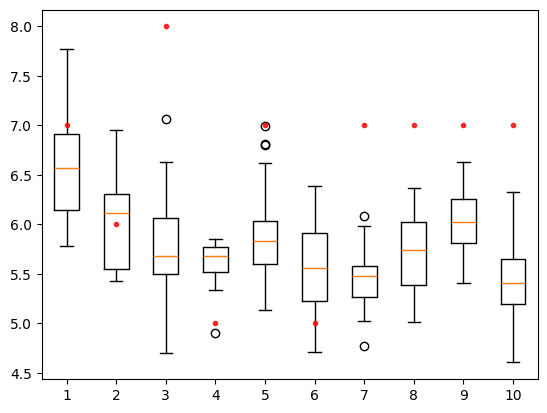

In [33]:
idx=np.random.choice(range(predictions.shape[0]), size=10, replace=False)
plt.boxplot(predictions[idx].T)
plt.plot(range(1,11), y_test[idx], 'r.', alpha=0.8);

## Full Bayesian Network

전체 베이시안 신경망을 구현하겠습니다. 이는 확률적 편향과 출력 가중치를 추가하는 것에 해당한다.

각 가중치/편향에 대한 후방은 여전히 독립적인 가우시안이다.

In [34]:
class FullBnnTorch(nn.Module):
    def __init__(self, input_dim, hidden_dim, activation=None):
        super(FullBnnTorch, self).__init__()
        # All parameters W, b + W_output + b_output
        n = input_dim * hidden_dim + hidden_dim + hidden_dim + 1
        self.mu = nn.Parameter(torch.zeros((n), dtype=torch.float32))
        self.rho  = nn.Parameter(torch.log(torch.expm1(torch.ones((n), dtype=torch.float32))))
        
        self.act = activation
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim
        self.prior = torch.distributions.Normal(loc=torch.zeros((n), device=device, dtype=torch.float32),
                                                scale=torch.ones((n), device=device, dtype=torch.float32))
        #self.posterior = torch.distributions.Normal(loc=self.mu, 
        #                                            scale=torch.log(1.+torch.exp(self.rho)))
        self.kl_func = torch.distributions.kl.kl_divergence
        self.batch_norm = torch.nn.BatchNorm1d(input_dim)

        
    def forward(self, inputs):
        inputs = self.batch_norm(inputs)
        q = torch.distributions.Normal(loc=self.mu, 
                                       scale=torch.log(1.+torch.exp(self.rho)))
        
        kl = torch.sum(self.kl_func(q, self.prior))
        # we use q.rsample() which uses the reparametrization trick instead of 
        # q.sample() which breaks the auto-differentation path
        all_w = q.rsample() 
        
        # split all_w into the different weight and biases matrices
        W_hidden = all_w[0:self.input_dim * self.hidden_dim].reshape((self.input_dim, self.hidden_dim))
        cur = self.input_dim * self.hidden_dim
        b_hidden = all_w[cur:cur + self.hidden_dim]
        cur = cur + self.hidden_dim
        W_output = all_w[cur:cur + self.hidden_dim].reshape((self.hidden_dim, 1))
        b_output = all_w[-2:-1]
        h = inputs @ W_hidden + b_hidden
        if self.act is not None:
            h = self.act(h)
        output = h @ W_output + b_output
        return output, kl

In [35]:
full_bnn_torch = FullBnnTorch(11, 32, torch.nn.functional.relu).to(device)
[p.numel() for p in full_bnn_torch.parameters()]
# 417 = 11*32 + 32 + 32*1 + 1

[417, 417, 11, 11]

100%|██████████| 400/400 [00:35<00:00, 11.22it/s]


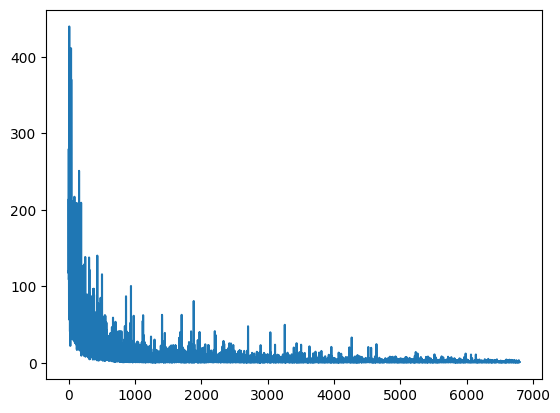

In [36]:
kl_weight = 1. / batch_size

def mse_kl_loss(model_outputs, y_true):
    y_hat, kl = model_outputs
    y_hat = torch.squeeze(y_hat)
    y_true = torch.squeeze(y_true)
    mse = torch.nn.MSELoss()(y_hat, y_true)
    return mse + kl * kl_weight

losses = train_model(full_bnn_torch, mse_kl_loss, 400)
plt.plot(losses);

In [38]:
# Example usage
predictions, y_test = compute_predictions(full_bnn_torch, dataset_test)
display_predictions(predictions, y_test)

100%|██████████| 735/735 [00:09<00:00, 78.04it/s]

Predictions mean: 5.82, min: 4.6, max: 7.54, range: 2.94 - Actual: 6.0
Predictions mean: 5.65, min: 4.43, max: 7.19, range: 2.76 - Actual: 6.0
Predictions mean: 5.32, min: 4.09, max: 7.18, range: 3.09 - Actual: 4.0
Predictions mean: 5.55, min: 4.51, max: 6.69, range: 2.18 - Actual: 5.0
Predictions mean: 6.38, min: 4.63, max: 8.2, range: 3.57 - Actual: 7.0
Predictions mean: 6.02, min: 4.81, max: 8.8, range: 3.99 - Actual: 6.0
Predictions mean: 5.71, min: 4.56, max: 6.82, range: 2.26 - Actual: 7.0
Predictions mean: 5.2, min: 4.39, max: 5.96, range: 1.57 - Actual: 5.0
Predictions mean: 6.84, min: 5.59, max: 8.63, range: 3.05 - Actual: 7.0
Predictions mean: 5.94, min: 4.53, max: 7.16, range: 2.63 - Actual: 6.0


In [39]:
errors = []
mean_prediction = np.mean(predictions,axis=-1)
for y_hat, y in zip(mean_prediction, y_test):
    errors.append((y_hat - y)**2)

rmse = np.sqrt(np.mean(np.concatenate(errors, axis=None)))
print(f"mean prediction RMSE: {round(rmse, 3):.3f}")

mean prediction RMSE: 0.810


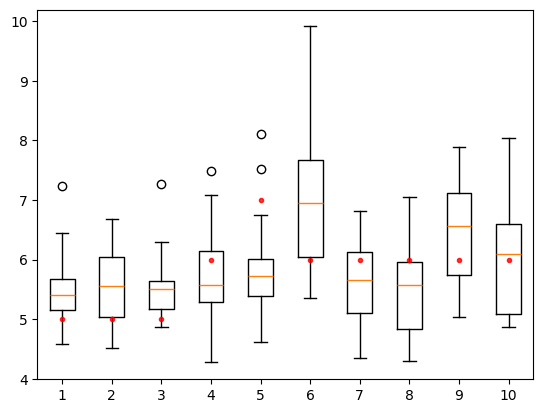

In [40]:
idx=np.random.choice(range(predictions.shape[0]), size=10, replace=False)
plt.boxplot(predictions[idx].T)
plt.plot(range(1,11), y_test[idx], 'r.', alpha=0.8);

## Going further

### A better prior

먼저 Scale Mixture prior를 실행한다, 
$$
P(w) = \prod_j π N(w_j |0, σ_1^2) + (1 − π)N (w_j |0, σ_2^2)
$$

일반적으로 $π = 1/2$, and $σ_1 > σ_2$.

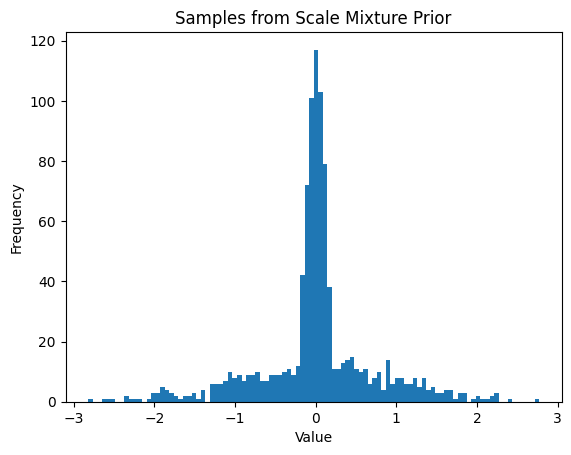

In [48]:
import torch.distributions as D

# Ensure 'device' is properly defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def scale_mix_prior(n):
    mix = D.Categorical(torch.ones(2, device=device))  # Ensure mix is on the correct device
    mu = torch.zeros((2, n), device=device, dtype=torch.float32)  # Ensure mu is on the correct device
    s1 = torch.ones((1, n), device=device, dtype=torch.float32) * 1.0  # Large variance
    s2 = torch.ones((1, n), device=device, dtype=torch.float32) * 0.1  # Small variance
    comp = D.Independent(D.Normal(mu, torch.cat((s1, s2), dim=0)), 1)  # Ensure all tensors are on the same device
    gmm = D.MixtureSameFamily(mix, comp)
    return gmm

# Plot the histogram
prior = scale_mix_prior(1)
samples = prior.sample((1000,))  # Sample 1000 points
plt.hist(samples[:, 0].cpu().numpy(), bins=100)  # Ensure samples are on CPU for plotting
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Samples from Scale Mixture Prior")
plt.show()

### KL_weight

제대로 조정하기 어렵고 학습에 큰 영향을 미친다. 고정된 값보다는 일정이 유용함

## Comparison with the parametrizing a distribution


지금까지는 가중치에 대한 분포가 있지만 각 입력에 대한 단일 포인트 추정치(가중치를 샘플링하면)가 있다.

<img src="https://raw.githubusercontent.com/charlesollion/dlexperiments/master/6-Bayesian-DL/stochasticNN.png" width="400" height="200">


단일 지점 추정치가 아닌 출력 분포를 모델링할 수도 있습니다. 마지막 레이어를 변경하여 가우시안 매개변수화를 출력으로 사용합니다. 이는 데이터의 불확실성, 감소 불가능한 노이즈, 데이터 생성 프로세스의 확률적 특성을 포착하는 것과 관련이 있어야 한다.

그런 다음 이 분포의 음의 로지스틱 가능성을 MSE 대신 손실 함수로 사용하며, 이 경우에는 확률적 가중치를 사용하지 않는다.

In [88]:
import torch.nn as nn

class DistributionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(DistributionModel, self).__init__()
        self.hidden_layer = nn.Linear(input_dim, hidden_dim)
        # We output two values, which will be interpreted as mu and log sigma of a distribution
        self.out_layer = nn.Linear(hidden_dim, 2)
        
        self.act = torch.relu
        
    def forward(self, inputs):
        h = self.hidden_layer(inputs)
        h = self.act(h)
        output = self.out_layer(h)
        mu, logscale = torch.split(output, [1,1], dim=-1)
        output = torch.distributions.Normal(loc=mu,
                                            scale=torch.exp(logscale))
        
        # we return a distribution instead of a single point estimate
        return output

In [89]:
distrib_model = DistributionModel(11, 32).to(device)
[p.numel() for p in distrib_model.parameters()]
# 11*32 + 32 + 32*2 + 2

[352, 32, 64, 2]

100%|██████████| 200/200 [00:15<00:00, 13.06it/s]


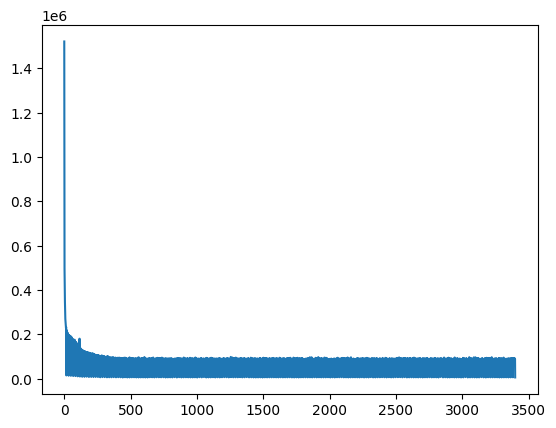

In [90]:
def nll_loss(model_outputs, y_true):
    return - torch.sum(model_outputs.log_prob(y_true))

losses = train_model(distrib_model, nll_loss, 200)
plt.plot(losses);

In [91]:
distrib_model.eval()
errors = []
intervals = []
for x,y in dataloader_test:
    d = distrib_model(x)
    y_hat = d.mean
    intervals.append(d.scale.detach().cpu().numpy())
    errors.append(((torch.squeeze(y_hat) - torch.squeeze(y))**2).detach().cpu().numpy())
    

rmse = np.sqrt(np.mean(np.concatenate(errors, axis=None)))
inter = np.mean(np.concatenate(intervals, axis=None)) * 1.96 * 2
print(f"mean prediction RMSE: {round(rmse, 3):.3f}")
print(f"average 95% confidence interval size: {round(inter, 3):.3f}")

mean prediction RMSE: 0.935
average 95% confidence interval size: 3.598


In [92]:
examples_torch[:len(samples)]

tensor([[-0.0604, -0.7727, -0.4483,  ...,  0.0071, -1.0511,  0.1548],
        [-0.2973, -0.8722,  5.5248,  ..., -0.6564, -1.5777, -1.4655],
        [ 1.3608,  3.8027,  3.2533,  ..., -1.7843,  1.6698, -0.8984],
        ...,
        [-0.5342, -1.7177, -0.3642,  ..., -0.1256,  0.5288,  0.1548],
        [-0.6526,  0.9182, -0.4483,  ...,  0.6706, -0.2612,  0.8840],
        [-0.1789,  0.2219,  1.3184,  ..., -0.4573, -0.3489, -0.4933]],
       device='cuda:0')

In [98]:
samples = 10

examples_torch, y_test = next(iter(dataloader_test))  # 라벨 포함 데이터 가져오기
predicted_d = distrib_model(examples_torch[:samples])
predicted_means = predicted_d.mean.detach().cpu().numpy()
predicted_sigmas = predicted_d.scale.detach().cpu().numpy()

upper = (predicted_means + (1.96 * predicted_sigmas)).tolist()
lower = (predicted_means - (1.96 * predicted_sigmas)).tolist()

for idx in range(samples):
    print(
        f"Prediction mean: {round(predicted_means[idx][0], 2):.2f}, "
        f"stddev: {round(predicted_sigmas[idx][0], 2):.2f}, "
        f"95% CI: [{round(upper[idx][0], 2)} - {round(lower[idx][0], 2)}]"
        f" - Actual: {y_test[idx].item()}"
    )

Prediction mean: 5.93, stddev: 0.91, 95% CI: [7.72 - 4.14] - Actual: 6.0
Prediction mean: 6.08, stddev: 0.94, 95% CI: [7.92 - 4.23] - Actual: 6.0
Prediction mean: 6.13, stddev: 0.91, 95% CI: [7.92 - 4.34] - Actual: 4.0
Prediction mean: 5.95, stddev: 0.91, 95% CI: [7.74 - 4.17] - Actual: 5.0
Prediction mean: 5.87, stddev: 0.92, 95% CI: [7.67 - 4.06] - Actual: 7.0
Prediction mean: 5.82, stddev: 0.92, 95% CI: [7.63 - 4.01] - Actual: 6.0
Prediction mean: 5.96, stddev: 0.91, 95% CI: [7.75 - 4.18] - Actual: 7.0
Prediction mean: 5.91, stddev: 0.93, 95% CI: [7.73 - 4.09] - Actual: 5.0
Prediction mean: 5.91, stddev: 0.92, 95% CI: [7.71 - 4.11] - Actual: 7.0
Prediction mean: 5.92, stddev: 0.92, 95% CI: [7.72 - 4.12] - Actual: 6.0


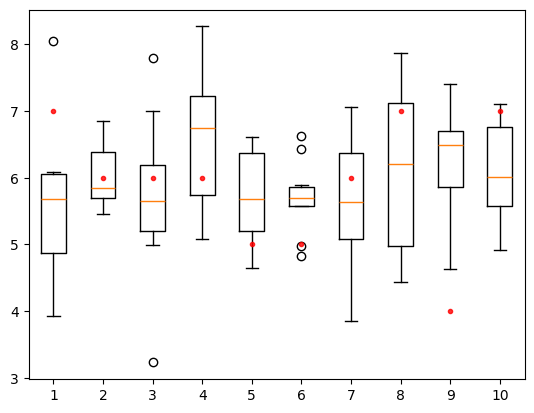

In [116]:
predictions = predicted_d.sample((20,))[:,:,0].detach().cpu()
plt.boxplot(predictions[idx].T)
plt.plot(range(1,11), y_test[idx].detach().cpu(), 'r.', alpha=0.8);